In [1]:
import torch
import torch.nn as nn  # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim  # optimizer
from torch.autograd import Variable # add gradients to tensors
from torch.nn import Parameter # model parameter functionality 

import pandas as pd
import numpy as np
import csv
import itertools

In [2]:
# Target labels
label_encodings3 = {
    'pants-fire': 0, 
    'false':      0, 
    'barely-true':1, 
    'half-true':  1, 
    'mostly-true':2,
    'true':       2
}
label_encodings6 = {
    'pants-fire': 0, 
    'false':      1, 
    'barely-true':2, 
    'half-true':  3, 
    'mostly-true':4,
    'true':       5
}

### FakeBERT

In [3]:
def get_accuracy(output, targets):

    predicted = [int(y_pred.detach().argmax(-1)) for y_pred in output]
    targets = [int(y) for y in targets]
    correct = sum(a==b for (a,b) in zip(predicted, targets))
    accuracy = 100*correct/len(targets) 

    return accuracy

def train(train_X,
          test_X,
          train_y,
          test_y,
          num_classes = 3,
          num_epochs = 10,
          batch_size = 10,
          learning_rate = 1e-4):
    
    # Instantiate model & optimization 
    model = FakeBERT(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Prepare test data
    test_y = torch.Tensor(test_y.values).to(dtype=torch.long)
    
    # Collect loss
    loss_func = nn.CrossEntropyLoss()
    loss_train, loss_test = [], []
    
    # Iterate over epochs
    for ep in range(num_epochs):
        
        model.train()
        temp_loss = []

        # Iterate over batches
        for i in range(train_X.shape[0]//batch_size):
            # Reset gradients
            optimizer.zero_grad()
            
            # Declare features and target labels
            X = train_X[i*batch_size:(i+1)*batch_size]
            y = train_y[i*batch_size:(i+1)*batch_size].values
            y = torch.Tensor(y).to(dtype=torch.long)

            # Get predictions from model
            pred = model(X)

            # Calculate loss
            loss = loss_func(pred, y)
            temp_loss.append(float(loss.detach()))
            
            # Backpropagate
            loss.backward()

            # Update parameters
            optimizer.step()
        
        # Record train loss
        loss_train.append(sum(temp_loss)/len(temp_loss))
        
        # Evaluate model
        model.eval()
            
        # Evaluate on test data
        test_pred = model(test_X)
        test_accuracy = get_accuracy(test_pred, test_y)
        loss_test.append(float(loss_func(test_pred, test_y).detach()))
        
        # Print accuracy
        print(f"Test accuracy: {test_accuracy} at epoch: {ep}")

    return model, loss_train, loss_test

In [4]:
class FakeBERT(nn.Module):
    def __init__(self, num_classes):
        super(FakeBERT, self).__init__()
        
        # Layer 1: Conv1D + Maxpool
        self.conv_1 = nn.Conv1d(in_channels=25, out_channels=32, kernel_size=3, stride=1)
        self.sigm_1 = nn.ReLU()
        self.pool_1 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 2: Conv1D + Maxpool
        self.conv_2 = nn.Conv1d(in_channels=25, out_channels=32, kernel_size=4, stride=1)
        self.sigm_2 = nn.ReLU()
        self.pool_2 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 3: Conv1D + Maxpool
        self.conv_3 = nn.Conv1d(in_channels=25, out_channels=32, kernel_size=5, stride=1)
        self.sigm_3 = nn.ReLU()
        self.pool_3 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 4: Conv1D + Maxpool
        self.conv_4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1)
        self.sigm_4 = nn.ReLU()
        self.pool_4 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 5: Conv1D + Maxpool
        self.conv_5 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1)
        self.sigm_5 = nn.ReLU()
        self.pool_5 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 6: Fully Connected Layer 
        self.full_6 = nn.Linear(544,32)
        self.sigm_6 = nn.Sigmoid()
        
        # Layer 7: Fully Connected Layer 
        self.full_7 = nn.Linear(32,num_classes)
        self.soft_7 = nn.Softmax()
        
    def forward(self, x):
        # Turn into tensor
        x = torch.Tensor(x)
        
        # Generate the 3 1D conv layers
        conv_1 = self.pool_1(self.sigm_1(self.conv_1(x)))        
        conv_2 = self.pool_2(self.sigm_2(self.conv_2(x)))        
        conv_3 = self.pool_3(self.sigm_3(self.conv_3(x)))
        
        # Concatenate the 3 layers
        cat = torch.cat((conv_1,conv_2,conv_3),2)
        
        # Pass the concatenated output through 2 1D conv layers
        conv_4 = self.pool_4(self.sigm_4(self.conv_4(cat)))        
        conv_5 = self.pool_5(self.sigm_5(self.conv_5(conv_4)))  

        # Flatten the output
        flat = conv_5.flatten(start_dim=1)

        # Pass through 2 fully connected layers
        full_6 = self.sigm_6(self.full_6(flat))
        full_7 = self.soft_7(self.full_7(full_6))
        
        return full_7

### Train

In [5]:
# Read in data
df_train = pd.read_csv("Data/liar_dataset/train.csv")
df_test = pd.read_csv("Data/liar_dataset/test.csv")
df_valid = pd.read_csv("Data/liar_dataset/valid.csv")

# Relabel
df_train['target'] = df_train['label'].apply(lambda x: label_encodings6[x])
df_test['target'] = df_test['label'].apply(lambda x: label_encodings6[x])
df_valid['target'] = df_valid['label'].apply(lambda x: label_encodings6[x])

# Load BERT Embeddings
pt_train = torch.load('train_bert.pt')
pt_test = torch.load('test_bert.pt')
pt_valid = torch.load('valid_bert.pt')

In [6]:
model, loss_train, loss_test = train(train_X=pt_train, 
                           test_X=pt_test,
                           train_y=df_train['target'], 
                           test_y=df_test['target'], 
                           num_epochs=100,
                           num_classes=6,
                           batch_size=10,
                           learning_rate=1e-4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Test accuracy: 20.915548539857934 at epoch: 0
Test accuracy: 20.915548539857934 at epoch: 1
Test accuracy: 20.915548539857934 at epoch: 2
Test accuracy: 20.915548539857934 at epoch: 3
Test accuracy: 20.915548539857934 at epoch: 4
Test accuracy: 21.783741120757696 at epoch: 5
Test accuracy: 22.099447513812155 at epoch: 6
Test accuracy: 22.099447513812155 at epoch: 7
Test accuracy: 21.783741120757696 at epoch: 8
Test accuracy: 21.783741120757696 at epoch: 9
Test accuracy: 21.54696132596685 at epoch: 10
Test accuracy: 21.70481452249408 at epoch: 11
Test accuracy: 21.783741120757696 at epoch: 12
Test accuracy: 22.099447513812155 at epoch: 13
Test accuracy: 22.257300710339383 at epoch: 14
Test accuracy: 22.573007103393845 at epoch: 15
Test accuracy: 22.730860299921073 at epoch: 16
Test accuracy: 23.04656669297553 at epoch: 17
Test accuracy: 22.65193370165746 at epoch: 18
Test accuracy: 22.730860299921073 at epoch: 19
Test accuracy: 23.441199684293608 at epoch: 20
Test accuracy: 23.756906077

In [7]:
# Evaluate on validation set
pred_valid = model(pt_valid)
get_accuracy(pred_valid, 
            torch.Tensor(df_valid['target'].values).to(dtype=torch.long))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


22.897196261682243

[[ 0 45 22 22 12 15]
 [ 0 71 58 61 38 35]
 [ 0 60 51 59 37 30]
 [ 0 49 56 73 52 18]
 [ 0 51 39 60 63 38]
 [ 0 27 29 32 45 36]]


<AxesSubplot:>

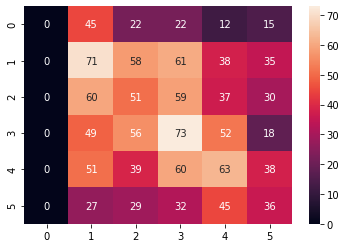

In [16]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
pred_valid_values = [np.argmax(pred_valid[i].detach().numpy(),0) for i in range(pred_valid.shape[0])]
cf_matrix = confusion_matrix(df_valid['target'].values, pred_valid_values)
print(cf_matrix)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [8]:
# Save losses
import pickle
with open('fakebert_bert_loss_train.data', 'wb') as filehandle:
    pickle.dump(loss_train, filehandle)
with open('fakebert_bert_loss_test.data', 'wb') as filehandle:
    pickle.dump(loss_test, filehandle)
    
# Save model
torch.save(model.state_dict(), "fakebert_bert_model.pt")